# Part 2: Re-track CAC40 Index

D'après la méthode de Heaton, on peut remarquer que la première partie de l'application (dans le research paper) a pour but la sélection d'un sous-ensemble d'actions du CAC40 Stock. Cette démarche vise à son tour de faire la même performance que l'index.

La méthode de Heaton possède 4 phases:

- Auto-Encoding
- Calibration
- Validation
- Vérification

In [1]:
# Run some setup code for this notebook.
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

Using TensorFlow backend.


** Phase 0: Loading Data **

- Nous avons 33 actions à étudier.

In [2]:
lastPricePath = 'data/CAC40/close.csv'
netChangePath = 'data/CAC40/rendement.csv'
percentageChangePath = 'data/CAC40/taux.csv'
stockPath = 'data/CAC40/CAC40.csv'

startDateCalibrate = 1
endDateCalibrate = 2004
startDateValidate = 2005
endDateValidate = 2025


# Load data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv(lastPricePath, index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[startDateCalibrate:endDateCalibrate+1, :]
stock['validate']['lp'] = stock_lp.iloc[startDateValidate:endDateValidate, :]
print("close: ",len(stock_lp.columns))

stock_net = pd.read_csv(netChangePath, index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[startDateCalibrate:endDateCalibrate+1, :]
stock['validate']['net'] = stock_net.iloc[startDateValidate:endDateValidate, :]
print("rendement: ", len(stock_net.columns))

stock_percentage = pd.read_csv(percentageChangePath, index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[startDateCalibrate:endDateCalibrate+1, :]
stock['validate']['percentage'] = stock_percentage.iloc[startDateValidate:endDateValidate, :]
print("taux de rendement", len(stock_percentage.columns))

# ibb
stockIndex = defaultdict(defaultdict)
stockIndex_full = pd.read_csv(stockPath, index_col=0).astype('float32')

stockIndex_lp = stockIndex_full.iloc[:,0] # Series
stockIndex['calibrate']['lp'] = stockIndex_lp[startDateCalibrate:endDateCalibrate+1]
stockIndex['validate']['lp'] = stockIndex_lp[startDateValidate:endDateValidate]

stockIndex_net = stockIndex_full.iloc[:,1] # Series
stockIndex['calibrate']['net'] = stockIndex_net[startDateCalibrate:endDateCalibrate+1]
stockIndex['validate']['net'] = stockIndex_net[startDateValidate:endDateValidate]

stockIndex_percentage = stockIndex_full.iloc[:,2] # Series
stockIndex['calibrate']['percentage'] = stockIndex_percentage[startDateCalibrate:endDateCalibrate+1]
stockIndex['validate']['percentage'] = stockIndex_percentage[startDateValidate:endDateValidate]

print(stockIndex_full.iloc[startDateCalibrate:startDateCalibrate+1,0])
print(stockIndex_full.iloc[endDateCalibrate:endDateCalibrate+1,0])
print(stockIndex_full.iloc[startDateValidate:startDateValidate+1,0])
print(stockIndex_full.iloc[endDateValidate:endDateValidate+1,0])

close:  33
rendement:  33
taux de rendement 33
Date
29/01/2010    3739.459961
Name: Close, dtype: float32
Date
29/11/2017    5398.049805
Name: Close, dtype: float32
Date
30/11/2017    5372.790039
Name: Close, dtype: float32
Date
02/01/2018    5288.600098
Name: Close, dtype: float32


In [3]:
stock_lp.head()

,AC.PA,ACA.PA,AI.PA,AIR.PA,ATO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,...,RI.PA,RNO.PA,SAF.PA,SOLB.BR,STM.PA,SU.PA,SW.PA,UG.PA,VIE.PA,VIV.PA
Date,,,,,,,,,,,,,,,,,,,,,
1/28/2010,25.540001,11.36,56.700001,13.78,33.740002,40.900002,51.070000,35.259998,31.719999,15.06,...,57.830002,33.939999,14.06,66.860001,5.92,36.880001,39.450001,16.820000,24.059999,18.250000
1/29/2010,25.790001,11.44,57.880001,14.20,33.740002,41.450001,52.150002,35.340000,32.259998,15.00,...,58.310001,34.259998,14.19,67.389999,5.95,37.509998,39.669998,17.059999,23.840000,18.240000
2/1/2010,25.850000,11.65,59.020000,14.28,34.180000,41.650002,52.900002,35.700001,32.740002,15.18,...,58.439999,35.310001,14.38,67.879997,6.05,37.650002,39.669998,17.360001,24.450001,17.799999
2/2/2010,26.190001,11.64,59.900002,14.61,34.509998,41.849998,53.880001,35.939999,32.810001,15.62,...,59.110001,35.290001,14.63,68.330002,6.16,38.490002,40.310001,17.180000,24.809999,18.010000
2/3/2010,25.850000,11.21,59.349998,14.63,34.430000,42.110001,52.540001,35.750000,33.000000,15.64,...,58.799999,35.320000,14.64,67.919998,6.20,38.529999,39.220001,17.270000,24.450001,18.040001


In [4]:
stock_net.head()

,AC.PA,ACA.PA,AI.PA,AIR.PA,ATO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,...,RI.PA,RNO.PA,SAF.PA,SOLB.BR,STM.PA,SU.PA,SW.PA,UG.PA,VIE.PA,VIV.PA
Date,,,,,,,,,,,,,,,,,,,,,
1/28/2010,-0.17,-0.20,-1.41,-0.02,-0.79,-1.06,-0.68,-0.72,-1.03,-0.23,...,-0.37,0.08,0.07,0.00,0.09,-1.40,-0.06,-0.41,-0.49,-0.42
1/29/2010,0.25,0.08,1.18,0.42,0.01,0.54,1.08,0.08,0.55,-0.05,...,0.48,0.32,0.13,0.53,0.03,0.64,0.22,0.24,-0.22,-0.01
2/1/2010,0.06,0.21,1.14,0.08,0.44,0.21,0.75,0.35,0.47,0.18,...,0.13,1.06,0.19,0.49,0.10,0.14,0.01,0.30,0.61,-0.44
2/2/2010,0.34,-0.02,0.89,0.33,0.33,0.20,0.98,0.24,0.07,0.44,...,0.67,-0.02,0.25,0.45,0.11,0.84,0.64,-0.18,0.35,0.21
2/3/2010,-0.35,-0.42,-0.55,0.02,-0.08,0.26,-1.34,-0.19,0.20,0.02,...,-0.31,0.03,0.02,-0.40,0.04,0.03,-1.09,0.10,-0.35,0.03


In [5]:
stock_percentage.head()

,AC.PA,ACA.PA,AI.PA,AIR.PA,ATO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,...,RI.PA,RNO.PA,SAF.PA,SOLB.BR,STM.PA,SU.PA,SW.PA,UG.PA,VIE.PA,VIV.PA
Date,,,,,,,,,,,,,,,,,,,,,
1/28/2010,-0.644530,-1.730852,-2.431990,-0.144980,-2.302340,-2.514299,-1.314010,-2.001117,-3.145515,-1.536952,...,-0.635737,0.251068,0.536481,0.000000,1.526587,-3.645153,-0.164510,-2.387197,-2.016289,-2.228984
1/29/2010,0.979525,0.748569,2.081676,3.085299,0.029637,1.320135,2.114748,0.226892,1.734192,-0.365327,...,0.830017,0.942837,0.924938,0.787321,0.540632,1.735590,0.570409,1.415980,-0.893785,-0.053152
2/1/2010,0.232237,1.835664,1.961297,0.528169,1.289083,0.494636,1.438159,1.004527,1.456693,1.166667,...,0.222943,3.079396,1.339443,0.725208,1.697194,0.373184,0.012607,1.755527,2.558729,-2.413669
2/2/2010,1.322095,-0.128755,1.503175,2.346760,0.980102,0.480182,1.852550,0.672366,0.213835,2.932455,...,1.146478,-0.056636,1.739130,0.664605,1.834104,2.230779,1.613106,-1.059914,1.451939,1.195960
2/3/2010,-1.318206,-3.652772,-0.916157,0.102669,-0.246267,0.621274,-2.487008,-0.514821,0.594422,0.128041,...,-0.524449,0.070837,0.102564,-0.591424,0.600357,0.090921,-2.703711,0.567074,-1.431159,0.161537


In [6]:
stockIndex_full.head()

,Close,Rendement,Taux de rendement,Volume
Date,,,,
28/01/2010,3688.790039,-71.010010,-1.888664,168079808.0
29/01/2010,3739.459961,50.669922,1.373619,149875808.0
01/02/2010,3762.010010,22.550049,0.603030,119833200.0
02/02/2010,3812.129883,50.119873,1.332263,134752608.0
03/02/2010,3793.469971,-18.659912,-0.489488,124554600.0


** Phase 1: Auto-encoding**

1. Apprentissage d'un auto-encoder afin de compresser l'information sur le marché (les actions du stock)
2. Classer les actions du Stock avec une norme 2
3. sélection d'un sous ensemble du stock comme un portefeuille
4. Page 7 dans le research paper: ReLU + linear comme des fonctions d'activation
5. Poids $W = (W_1, W_2)$, L2 regularization

In [7]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_net.columns) 

# connect all layers
input_img = Input(shape=(num_stock,))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, batch_size = 10, epochs=500, shuffle=False)
autoencoder.save('model/CAC40/autoencoder.h5')

# how well is our re-construct matrix?
reconstruct = autoencoder.predict(data)

Epoch 1/500
2004/2004 [==============================] - 2s 915us/step - loss: 1.2860
Epoch 2/500
2004/2004 [==============================] - ETA: 0s - loss: 1.066 - 1s 332us/step - loss: 1.0821
Epoch 3/500
2004/2004 [==============================] - 1s 353us/step - loss: 0.9489
Epoch 4/500
2004/2004 [==============================] - 1s 346us/step - loss: 0.8644
Epoch 5/500
2004/2004 [==============================] - 1s 371us/step - loss: 0.7946
Epoch 6/500
2004/2004 [==============================] - 1s 453us/step - loss: 0.7175
Epoch 7/500
2004/2004 [==============================] - 1s 437us/step - loss: 0.6519
Epoch 8/500
2004/2004 [==============================] - 1s 435us/step - loss: 0.6137
Epoch 9/500
2004/2004 [==============================] - 1s 448us/step - loss: 0.5938
Epoch 10/500
2004/2004 [==============================] - 1s 479us/step - loss: 0.5816
Epoch 11/500
2004/2004 [==============================] - 1s 440us/step - loss: 0.5722
Epoch 12/500
2004/2004 [====

2004/2004 [==============================] - 1s 394us/step - loss: 0.3989
Epoch 187/500
2004/2004 [==============================] - 1s 374us/step - loss: 0.3988
Epoch 188/500
2004/2004 [==============================] - 1s 422us/step - loss: 0.3987
Epoch 189/500
2004/2004 [==============================] - 1s 310us/step - loss: 0.3986
Epoch 190/500
2004/2004 [==============================] - 1s 289us/step - loss: 0.3986
Epoch 191/500
2004/2004 [==============================] - 1s 301us/step - loss: 0.3985
Epoch 192/500
2004/2004 [==============================] - 1s 304us/step - loss: 0.3984
Epoch 193/500
2004/2004 [==============================] - 1s 302us/step - loss: 0.3983
Epoch 194/500
2004/2004 [==============================] - 1s 306us/step - loss: 0.3982 0s - loss
Epoch 195/500
2004/2004 [==============================] - 1s 303us/step - loss: 0.3982
Epoch 196/500
2004/2004 [==============================] - 1s 301us/step - loss: 0.3981
Epoch 197/500
2004/2004 [===========

2004/2004 [==============================] - 1s 331us/step - loss: 0.3912
Epoch 371/500
2004/2004 [==============================] - 1s 353us/step - loss: 0.3911
Epoch 372/500
2004/2004 [==============================] - 1s 350us/step - loss: 0.3911
Epoch 373/500
2004/2004 [==============================] - 1s 343us/step - loss: 0.3911
Epoch 374/500
2004/2004 [==============================] - 1s 414us/step - loss: 0.3911
Epoch 375/500
2004/2004 [==============================] - 1s 506us/step - loss: 0.3911
Epoch 376/500
2004/2004 [==============================] - 1s 377us/step - loss: 0.3910
Epoch 377/500
2004/2004 [==============================] - 1s 403us/step - loss: 0.3910
Epoch 378/500
2004/2004 [==============================] - 1s 301us/step - loss: 0.3910
Epoch 379/500
2004/2004 [==============================] - 1s 320us/step - loss: 0.3910
Epoch 380/500
2004/2004 [==============================] - 1s 288us/step - loss: 0.3910
Epoch 381/500
2004/2004 [=====================

** Communal Information **

- calculer les normes 2 $||X - \hat{X}||$
- L'action, celle qui la minimum valeur en norme 2, a le role le plus important dans la compression des données du marché dans l'auto-encoder

In [8]:
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock number | 2-norm | stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index,"|", communal_information[stock_index],"|", stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock number | 2-norm | stock name
21 | 6.685972213745117 | ORA.PA
1 | 6.712449073791504 | ACA.PA
27 | 6.819112777709961 | STM.PA
9 | 9.043715476989746 | CS.PA
32 | 9.773581504821777 | VIV.PA
30 | 10.287758827209473 | UG.PA
31 | 10.333895683288574 | VIE.PA
7 | 14.915628433227539 | CA.PA
15 | 16.444833755493164 | KER.PA
16 | 17.382877349853516 | LR.PA
12 | 18.525318145751953 | FP.PA
0 | 19.09077262878418 | AC.PA
13 | 19.394311904907227 | FR.PA
5 | 19.915502548217773 | BN.PA
10 | 20.6186580657959 | DG.PA
26 | 23.334304809570312 | SOLB.BR
14 | 23.767873764038086 | GLE.PA
25 | 25.279621124267578 | SAF.PA
22 | 26.52578353881836 | PUB.PA
28 | 26.66683578491211 | SU.PA
6 | 26.67767333984375 | BNP.PA
3 | 27.154619216918945 | AIR.PA
20 | 28.38020896911621 | OR.PA
29 | 29.93191909790039 | SW.PA
19 | 30.434518814086914 | MT.AS
8 | 31.040658950805664 | CAP.PA
2 | 31.45452880859375 | AI.PA
23 | 32.85578155517578 | RI.PA
4 | 33.22970199584961 | ATO.PA
11 | 34.23685073852539 | EI.PA
18 | 34.300285339

Notre Auto-encoder est construit maintenant. Nous allons tracer les actions (auto-encoded).

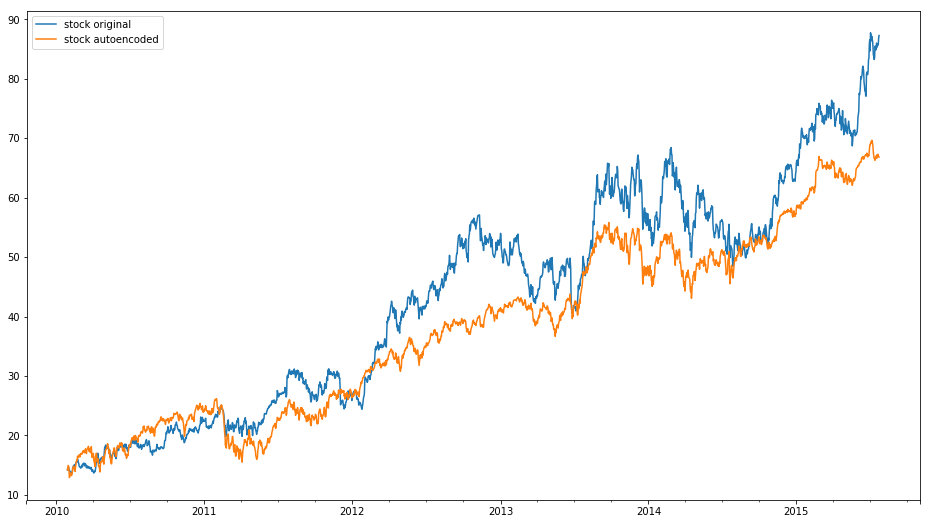

In [9]:
which_stock = 3

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum() # the stock evolution from net change values 
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock]) # add the initial stock value

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/28/2010', periods=2004, freq='D')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/28/2010', periods = 2004,freq='D')).plot(label='stock autoencoded', legend=True)

**Phase 2: Calibration**

- x : taux de rendement du portefeuille construit
- y : taux de rendement de l'indice du stock

In [10]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [5,15,25]:  
    # some numerical values
    encoding_dim = 5
    s = 5 + non_communal
    stock_index = np.concatenate((ranking[0:5], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.001))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = stockIndex['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
   
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 100)    # fit the model
    deep_learner.save('model/CAC40/s(' + str(s) + ')' + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = stockIndex['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - stockIndex['calibrate']['lp']))

Epoch 1/500
2004/2004 [==============================] - 1s 412us/step - loss: 2.0130
Epoch 2/500
2004/2004 [==============================] - 0s 42us/step - loss: 0.6932
Epoch 3/500
2004/2004 [==============================] - 0s 38us/step - loss: 0.4884
Epoch 4/500
2004/2004 [==============================] - 0s 43us/step - loss: 0.4030
Epoch 5/500
2004/2004 [==============================] - 0s 36us/step - loss: 0.3491
Epoch 6/500
2004/2004 [==============================] - 0s 27us/step - loss: 0.3111
Epoch 7/500
2004/2004 [==============================] - 0s 23us/step - loss: 0.2835
Epoch 8/500
2004/2004 [==============================] - 0s 24us/step - loss: 0.2627
Epoch 9/500
2004/2004 [==============================] - 0s 24us/step - loss: 0.2469
Epoch 10/500
2004/2004 [==============================] - 0s 26us/step - loss: 0.2346
Epoch 11/500
2004/2004 [==============================] - 0s 48us/step - loss: 0.2247
Epoch 12/500
2004/2004 [==============================] - 0s 6

2004/2004 [==============================] - 0s 46us/step - loss: 0.1365
Epoch 190/500
2004/2004 [==============================] - 0s 33us/step - loss: 0.1365
Epoch 191/500
2004/2004 [==============================] - 0s 29us/step - loss: 0.1364
Epoch 192/500
2004/2004 [==============================] - 0s 34us/step - loss: 0.1364
Epoch 193/500
2004/2004 [==============================] - 0s 36us/step - loss: 0.1364
Epoch 194/500
2004/2004 [==============================] - 0s 34us/step - loss: 0.1364
Epoch 195/500
2004/2004 [==============================] - 0s 35us/step - loss: 0.1363
Epoch 196/500
2004/2004 [==============================] - 0s 43us/step - loss: 0.1363
Epoch 197/500
2004/2004 [==============================] - 0s 32us/step - loss: 0.1363
Epoch 198/500
2004/2004 [==============================] - 0s 33us/step - loss: 0.1363
Epoch 199/500
2004/2004 [==============================] - 0s 31us/step - loss: 0.1362
Epoch 200/500
2004/2004 [==============================] 

Epoch 376/500
2004/2004 [==============================] - 0s 45us/step - loss: 0.1342
Epoch 377/500
2004/2004 [==============================] - 0s 44us/step - loss: 0.1342
Epoch 378/500
2004/2004 [==============================] - 0s 36us/step - loss: 0.1342
Epoch 379/500
2004/2004 [==============================] - 0s 30us/step - loss: 0.1342
Epoch 380/500
2004/2004 [==============================] - 0s 26us/step - loss: 0.1342
Epoch 381/500
2004/2004 [==============================] - 0s 25us/step - loss: 0.1342
Epoch 382/500
2004/2004 [==============================] - 0s 28us/step - loss: 0.1342
Epoch 383/500
2004/2004 [==============================] - 0s 30us/step - loss: 0.1342
Epoch 384/500
2004/2004 [==============================] - 0s 23us/step - loss: 0.1342
Epoch 385/500
2004/2004 [==============================] - 0s 25us/step - loss: 0.1342
Epoch 386/500
2004/2004 [==============================] - 0s 24us/step - loss: 0.1342
Epoch 387/500
2004/2004 [==================

2004/2004 [==============================] - 0s 39us/step - loss: 0.0936
Epoch 65/500
2004/2004 [==============================] - 0s 39us/step - loss: 0.0932
Epoch 66/500
2004/2004 [==============================] - 0s 51us/step - loss: 0.0929
Epoch 67/500
2004/2004 [==============================] - 0s 36us/step - loss: 0.0925
Epoch 68/500
2004/2004 [==============================] - 0s 39us/step - loss: 0.0922
Epoch 69/500
2004/2004 [==============================] - 0s 37us/step - loss: 0.0918
Epoch 70/500
2004/2004 [==============================] - 0s 31us/step - loss: 0.0915
Epoch 71/500
2004/2004 [==============================] - 0s 32us/step - loss: 0.0912
Epoch 72/500
2004/2004 [==============================] - 0s 38us/step - loss: 0.0909
Epoch 73/500
2004/2004 [==============================] - 0s 34us/step - loss: 0.0906
Epoch 74/500
2004/2004 [==============================] - 0s 25us/step - loss: 0.0903
Epoch 75/500
2004/2004 [==============================] - 0s 27us/s

2004/2004 [==============================] - 0s 36us/step - loss: 0.0759
Epoch 252/500
2004/2004 [==============================] - 0s 38us/step - loss: 0.0759
Epoch 253/500
2004/2004 [==============================] - 0s 25us/step - loss: 0.0758
Epoch 254/500
2004/2004 [==============================] - 0s 22us/step - loss: 0.0758
Epoch 255/500
2004/2004 [==============================] - 0s 22us/step - loss: 0.0758
Epoch 256/500
2004/2004 [==============================] - ETA: 0s - loss: 0.350 - 0s 23us/step - loss: 0.0758
Epoch 257/500
2004/2004 [==============================] - 0s 39us/step - loss: 0.0758
Epoch 258/500
2004/2004 [==============================] - 0s 25us/step - loss: 0.0757
Epoch 259/500
2004/2004 [==============================] - 0s 24us/step - loss: 0.0757
Epoch 260/500
2004/2004 [==============================] - 0s 22us/step - loss: 0.0757
Epoch 261/500
2004/2004 [==============================] - 0s 22us/step - loss: 0.0757
Epoch 262/500
2004/2004 [========

2004/2004 [==============================] - 0s 19us/step - loss: 0.0744
Epoch 346/500
2004/2004 [==============================] - 0s 14us/step - loss: 0.0744
Epoch 347/500
2004/2004 [==============================] - 0s 17us/step - loss: 0.0744
Epoch 348/500
2004/2004 [==============================] - 0s 16us/step - loss: 0.0744
Epoch 349/500
2004/2004 [==============================] - 0s 21us/step - loss: 0.0744
Epoch 350/500
2004/2004 [==============================] - 0s 18us/step - loss: 0.0744
Epoch 351/500
2004/2004 [==============================] - 0s 19us/step - loss: 0.0744
Epoch 352/500
2004/2004 [==============================] - 0s 19us/step - loss: 0.0744
Epoch 353/500
2004/2004 [==============================] - 0s 21us/step - loss: 0.0744
Epoch 354/500
2004/2004 [==============================] - 0s 17us/step - loss: 0.0743
Epoch 355/500
2004/2004 [==============================] - 0s 16us/step - loss: 0.0743
Epoch 356/500
2004/2004 [==============================] 

2004/2004 [==============================] - 0s 12us/step - loss: 0.0967
Epoch 33/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0953
Epoch 34/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0940
Epoch 35/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0927
Epoch 36/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0915
Epoch 37/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0904
Epoch 38/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0893
Epoch 39/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0882
Epoch 40/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0873
Epoch 41/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0863
Epoch 42/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0854
Epoch 43/500
2004/2004 [==============================] - 0s 12us/s

2004/2004 [==============================] - 0s 12us/step - loss: 0.0494
Epoch 221/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0493
Epoch 222/500
2004/2004 [==============================] - 0s 11us/step - loss: 0.0493
Epoch 223/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0492
Epoch 224/500
2004/2004 [==============================] - 0s 17us/step - loss: 0.0492
Epoch 225/500
2004/2004 [==============================] - 0s 16us/step - loss: 0.0491
Epoch 226/500
2004/2004 [==============================] - 0s 15us/step - loss: 0.0491
Epoch 227/500
2004/2004 [==============================] - 0s 15us/step - loss: 0.0490
Epoch 228/500
2004/2004 [==============================] - 0s 14us/step - loss: 0.0490
Epoch 229/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0490
Epoch 230/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0489
Epoch 231/500
2004/2004 [==============================] 

2004/2004 [==============================] - 0s 13us/step - loss: 0.0448
Epoch 408/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0448
Epoch 409/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0447
Epoch 410/500
2004/2004 [==============================] - 0s 14us/step - loss: 0.0447
Epoch 411/500
2004/2004 [==============================] - 0s 12us/step - loss: 0.0447
Epoch 412/500
2004/2004 [==============================] - 0s 18us/step - loss: 0.0447
Epoch 413/500
2004/2004 [==============================] - 0s 14us/step - loss: 0.0447
Epoch 414/500
2004/2004 [==============================] - 0s 13us/step - loss: 0.0447
Epoch 415/500
2004/2004 [==============================] - 0s 15us/step - loss: 0.0447
Epoch 416/500
2004/2004 [==============================] - 0s 22us/step - loss: 0.0447
Epoch 417/500
2004/2004 [==============================] - 0s 18us/step - loss: 0.0446
Epoch 418/500
2004/2004 [==============================] 

Maintenant, on trace la performance des trois portefeuilles construits.

S(10) 2-norm difference:  20155.3
S(20) 2-norm difference:  21107.7
S(30) 2-norm difference:  14918.6


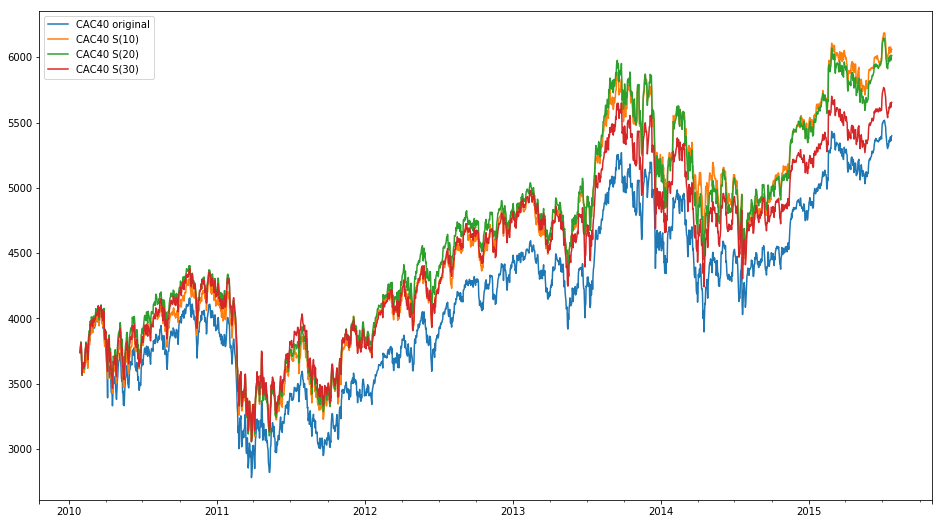

In [11]:
# plot results and 2-norm differences
pd.Series(stockIndex['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/28/2010', periods=2004, freq='D')).plot(label='CAC40 original', legend=True) 
for s in [10, 20, 30]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/28/2010', periods = 2004,freq='D')).plot(label='CAC40 S('+str(s)+')', legend=True)
    print("S(" +str(s)+")" + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    

** Phase 3: Validation**

In [12]:
for non_communal in [5, 15, 25]:  
    # some numerical values
    encoding_dim = 5
    s = 5 + non_communal
    stock_index = np.concatenate((ranking[0:5], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/CAC40/s(' + str(s) + ')' + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    y = stockIndex['validate']['percentage']

    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = stockIndex['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - stockIndex['validate']['lp']))

On prédit l'indice du CAC40 avec les données de validation pour les 3 portefeuilles construits.

S(10) 2-norm difference:  224.591
S(20) 2-norm difference:  134.337
S(30) 2-norm difference:  70.5578


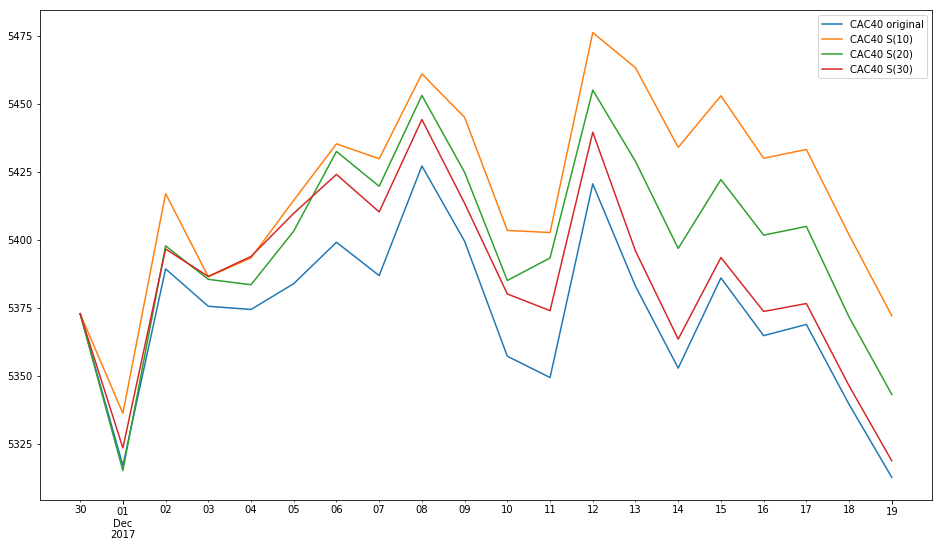

In [13]:
# plot results and 2-norm differences
pd.Series(stockIndex['validate']['lp'].as_matrix(), index=pd.date_range(start='11/30/2017', periods=20, freq='D')).plot(label='CAC40 original', legend=True) 
for s in [10, 20, 30]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='11/30/2017', periods = 20,freq='D')).plot(label='CAC40 S('+str(s)+')', legend=True)
    print("S(" +str(s) +")" + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

**Phase 4: Vérification**

- axe des x: erreur en norme 2  
- axe des y: les portefeuilles construits 60, 40, 20


In [14]:
error = []
for non_communal in range(5, 26,5):  
    # some numerical values
    encoding_dim = 5
    s = 5 + non_communal
    stock_index = np.concatenate((ranking[0:5], ranking[-non_communal:])) # portfolio index


    # trainning
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = stockIndex['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = stockIndex['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = stockIndex['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - stockIndex['validate']['lp'])))    

Epoch 1/500
2004/2004 [==============================] - 1s 507us/step - loss: 0.5222
Epoch 2/500
2004/2004 [==============================] - 0s 196us/step - loss: 0.2431
Epoch 3/500
2004/2004 [==============================] - 0s 184us/step - loss: 0.2141
Epoch 4/500
2004/2004 [==============================] - 0s 142us/step - loss: 0.1991
Epoch 5/500
2004/2004 [==============================] - 0s 130us/step - loss: 0.1892
Epoch 6/500
2004/2004 [==============================] - 0s 130us/step - loss: 0.1828
Epoch 7/500
2004/2004 [==============================] - 1s 598us/step - loss: 0.1783
Epoch 8/500
2004/2004 [==============================] - 1s 443us/step - loss: 0.1751
Epoch 9/500
2004/2004 [==============================] - 1s 447us/step - loss: 0.1724
Epoch 10/500
2004/2004 [==============================] - 1s 412us/step - loss: 0.1701
Epoch 11/500
2004/2004 [==============================] - 1s 339us/step - loss: 0.1682 0s -
Epoch 12/500
2004/2004 [=======================

2004/2004 [==============================] - 0s 104us/step - loss: 0.1538
Epoch 96/500
2004/2004 [==============================] - 0s 101us/step - loss: 0.1539
Epoch 97/500
2004/2004 [==============================] - 0s 105us/step - loss: 0.1538
Epoch 98/500
2004/2004 [==============================] - 0s 104us/step - loss: 0.1538
Epoch 99/500
2004/2004 [==============================] - 0s 131us/step - loss: 0.1539
Epoch 100/500
2004/2004 [==============================] - 0s 98us/step - loss: 0.1538
Epoch 101/500
2004/2004 [==============================] - 0s 107us/step - loss: 0.1538
Epoch 102/500
2004/2004 [==============================] - 0s 105us/step - loss: 0.1538
Epoch 103/500
2004/2004 [==============================] - 0s 100us/step - loss: 0.1538
Epoch 104/500
2004/2004 [==============================] - 0s 204us/step - loss: 0.1538
Epoch 105/500
2004/2004 [==============================] - 1s 618us/step - loss: 0.1538
Epoch 106/500
2004/2004 [==========================

Epoch 280/500
2004/2004 [==============================] - 1s 265us/step - loss: 0.1537
Epoch 281/500
2004/2004 [==============================] - 1s 263us/step - loss: 0.1537
Epoch 282/500
2004/2004 [==============================] - 0s 244us/step - loss: 0.1538
Epoch 283/500
2004/2004 [==============================] - 0s 247us/step - loss: 0.1537
Epoch 284/500
2004/2004 [==============================] - 1s 251us/step - loss: 0.1537
Epoch 285/500
2004/2004 [==============================] - 1s 287us/step - loss: 0.1537
Epoch 286/500
2004/2004 [==============================] - 1s 283us/step - loss: 0.1538
Epoch 287/500
2004/2004 [==============================] - 1s 262us/step - loss: 0.1537
Epoch 288/500
2004/2004 [==============================] - 1s 277us/step - loss: 0.1537
Epoch 289/500
2004/2004 [==============================] - 1s 274us/step - loss: 0.1537
Epoch 290/500
2004/2004 [==============================] - 1s 304us/step - loss: 0.1537
Epoch 291/500
2004/2004 [=======

2004/2004 [==============================] - 1s 299us/step - loss: 0.1538
Epoch 374/500
2004/2004 [==============================] - 1s 314us/step - loss: 0.1537
Epoch 375/500
2004/2004 [==============================] - 1s 346us/step - loss: 0.1537
Epoch 376/500
2004/2004 [==============================] - 1s 300us/step - loss: 0.1537
Epoch 377/500
2004/2004 [==============================] - 1s 337us/step - loss: 0.1538
Epoch 378/500
2004/2004 [==============================] - 1s 351us/step - loss: 0.1538
Epoch 379/500
2004/2004 [==============================] - 1s 333us/step - loss: 0.1537
Epoch 380/500
2004/2004 [==============================] - 1s 307us/step - loss: 0.1537
Epoch 381/500
2004/2004 [==============================] - 1s 279us/step - loss: 0.1537
Epoch 382/500
2004/2004 [==============================] - 1s 254us/step - loss: 0.1537
Epoch 383/500
2004/2004 [==============================] - 0s 244us/step - loss: 0.1537
Epoch 384/500
2004/2004 [=====================

Epoch 466/500
2004/2004 [==============================] - 0s 244us/step - loss: 0.1537
Epoch 467/500
2004/2004 [==============================] - 1s 260us/step - loss: 0.1537
Epoch 468/500
2004/2004 [==============================] - 1s 265us/step - loss: 0.1537
Epoch 469/500
2004/2004 [==============================] - 1s 259us/step - loss: 0.1538
Epoch 470/500
2004/2004 [==============================] - 0s 244us/step - loss: 0.1537
Epoch 471/500
2004/2004 [==============================] - 1s 255us/step - loss: 0.1537
Epoch 472/500
2004/2004 [==============================] - 1s 333us/step - loss: 0.1538
Epoch 473/500
2004/2004 [==============================] - 0s 212us/step - loss: 0.1537
Epoch 474/500
2004/2004 [==============================] - 0s 210us/step - loss: 0.1537
Epoch 475/500
2004/2004 [==============================] - 0s 239us/step - loss: 0.1538
Epoch 476/500
2004/2004 [==============================] - 0s 235us/step - loss: 0.1537
Epoch 477/500
2004/2004 [=======

2004/2004 [==============================] - 1s 252us/step - loss: 0.1222
Epoch 153/500
2004/2004 [==============================] - 1s 266us/step - loss: 0.1222
Epoch 154/500
2004/2004 [==============================] - 0s 249us/step - loss: 0.1221
Epoch 155/500
2004/2004 [==============================] - 0s 248us/step - loss: 0.1221
Epoch 156/500
2004/2004 [==============================] - 1s 270us/step - loss: 0.1221
Epoch 157/500
2004/2004 [==============================] - 1s 250us/step - loss: 0.1221
Epoch 158/500
2004/2004 [==============================] - 0s 246us/step - loss: 0.1221
Epoch 159/500
2004/2004 [==============================] - 1s 252us/step - loss: 0.1221
Epoch 160/500
2004/2004 [==============================] - 1s 261us/step - loss: 0.1221
Epoch 161/500
2004/2004 [==============================] - 1s 252us/step - loss: 0.1221
Epoch 162/500
2004/2004 [==============================] - 1s 264us/step - loss: 0.1222
Epoch 163/500
2004/2004 [=====================

2004/2004 [==============================] - 1s 374us/step - loss: 0.1220
Epoch 337/500
2004/2004 [==============================] - 1s 292us/step - loss: 0.1220
Epoch 338/500
2004/2004 [==============================] - 1s 288us/step - loss: 0.1220
Epoch 339/500
2004/2004 [==============================] - 1s 269us/step - loss: 0.1220
Epoch 340/500
2004/2004 [==============================] - 0s 244us/step - loss: 0.1220
Epoch 341/500
2004/2004 [==============================] - 0s 238us/step - loss: 0.1220
Epoch 342/500
2004/2004 [==============================] - 1s 296us/step - loss: 0.1221
Epoch 343/500
2004/2004 [==============================] - 1s 271us/step - loss: 0.1220
Epoch 344/500
2004/2004 [==============================] - 1s 261us/step - loss: 0.1220
Epoch 345/500
2004/2004 [==============================] - 1s 352us/step - loss: 0.1220
Epoch 346/500
2004/2004 [==============================] - 1s 495us/step - loss: 0.1220 0s - los
Epoch 347/500
2004/2004 [============

2004/2004 [==============================] - 1s 296us/step - loss: 0.0967
Epoch 22/500
2004/2004 [==============================] - 1s 350us/step - loss: 0.0957 0s - 
Epoch 23/500
2004/2004 [==============================] - 1s 263us/step - loss: 0.0952
Epoch 24/500
2004/2004 [==============================] - 0s 240us/step - loss: 0.0944
Epoch 25/500
2004/2004 [==============================] - 0s 247us/step - loss: 0.0939
Epoch 26/500
2004/2004 [==============================] - 0s 241us/step - loss: 0.0934
Epoch 27/500
2004/2004 [==============================] - 0s 249us/step - loss: 0.0929
Epoch 28/500
2004/2004 [==============================] - 0s 244us/step - loss: 0.0925
Epoch 29/500
2004/2004 [==============================] - 1s 257us/step - loss: 0.0922
Epoch 30/500
2004/2004 [==============================] - 0s 249us/step - loss: 0.0920
Epoch 31/500
2004/2004 [==============================] - 1s 260us/step - loss: 0.0916
Epoch 32/500
2004/2004 [==========================

Epoch 115/500
2004/2004 [==============================] - 1s 253us/step - loss: 0.0887
Epoch 116/500
2004/2004 [==============================] - 1s 509us/step - loss: 0.0889
Epoch 117/500
2004/2004 [==============================] - 1s 382us/step - loss: 0.0887
Epoch 118/500
2004/2004 [==============================] - 1s 359us/step - loss: 0.0889
Epoch 119/500
2004/2004 [==============================] - 1s 279us/step - loss: 0.0887
Epoch 120/500
2004/2004 [==============================] - 1s 364us/step - loss: 0.0887
Epoch 121/500
2004/2004 [==============================] - 0s 235us/step - loss: 0.0887
Epoch 122/500
2004/2004 [==============================] - 1s 287us/step - loss: 0.0887
Epoch 123/500
2004/2004 [==============================] - 1s 299us/step - loss: 0.0887
Epoch 124/500
2004/2004 [==============================] - 1s 298us/step - loss: 0.0887
Epoch 125/500
2004/2004 [==============================] - 1s 257us/step - loss: 0.0887
Epoch 126/500
2004/2004 [=======

2004/2004 [==============================] - 1s 450us/step - loss: 0.0887
Epoch 301/500
2004/2004 [==============================] - 1s 441us/step - loss: 0.0887
Epoch 302/500
2004/2004 [==============================] - 1s 326us/step - loss: 0.0887
Epoch 303/500
2004/2004 [==============================] - 1s 340us/step - loss: 0.0885 0s - 
Epoch 304/500
2004/2004 [==============================] - 1s 311us/step - loss: 0.0886
Epoch 305/500
2004/2004 [==============================] - 1s 355us/step - loss: 0.0887
Epoch 306/500
2004/2004 [==============================] - 1s 399us/step - loss: 0.0887
Epoch 307/500
2004/2004 [==============================] - 1s 311us/step - loss: 0.0887
Epoch 308/500
2004/2004 [==============================] - 1s 261us/step - loss: 0.0885
Epoch 309/500
2004/2004 [==============================] - 1s 274us/step - loss: 0.0886
Epoch 310/500
2004/2004 [==============================] - 1s 251us/step - loss: 0.0886
Epoch 311/500
2004/2004 [===============

2004/2004 [==============================] - 1s 452us/step - loss: 0.0886
Epoch 485/500
2004/2004 [==============================] - 1s 427us/step - loss: 0.0886
Epoch 486/500
2004/2004 [==============================] - 1s 408us/step - loss: 0.0885
Epoch 487/500
2004/2004 [==============================] - 1s 631us/step - loss: 0.0887
Epoch 488/500
2004/2004 [==============================] - 1s 409us/step - loss: 0.0885
Epoch 489/500
2004/2004 [==============================] - 1s 434us/step - loss: 0.0886
Epoch 490/500
2004/2004 [==============================] - 1s 397us/step - loss: 0.0885
Epoch 491/500
2004/2004 [==============================] - 1s 325us/step - loss: 0.0885
Epoch 492/500
2004/2004 [==============================] - 1s 327us/step - loss: 0.0886
Epoch 493/500
2004/2004 [==============================] - 1s 368us/step - loss: 0.0886
Epoch 494/500
2004/2004 [==============================] - 1s 351us/step - loss: 0.0885
Epoch 495/500
2004/2004 [=====================

2004/2004 [==============================] - 1s 304us/step - loss: 0.0739
Epoch 170/500
2004/2004 [==============================] - 1s 279us/step - loss: 0.0741
Epoch 171/500
2004/2004 [==============================] - 1s 345us/step - loss: 0.0738
Epoch 172/500
2004/2004 [==============================] - 1s 401us/step - loss: 0.0739
Epoch 173/500
2004/2004 [==============================] - 1s 434us/step - loss: 0.0738
Epoch 174/500
2004/2004 [==============================] - 1s 299us/step - loss: 0.0741
Epoch 175/500
2004/2004 [==============================] - 1s 324us/step - loss: 0.0738
Epoch 176/500
2004/2004 [==============================] - 1s 434us/step - loss: 0.0740 0s
Epoch 177/500
2004/2004 [==============================] - 0s 203us/step - loss: 0.0740
Epoch 178/500
2004/2004 [==============================] - 0s 213us/step - loss: 0.0738
Epoch 179/500
2004/2004 [==============================] - 0s 233us/step - loss: 0.0741
Epoch 180/500
2004/2004 [==================

2004/2004 [==============================] - 0s 202us/step - loss: 0.0736
Epoch 356/500
2004/2004 [==============================] - 0s 177us/step - loss: 0.0736
Epoch 357/500
2004/2004 [==============================] - 0s 171us/step - loss: 0.0736 0s - loss: 0.
Epoch 358/500
2004/2004 [==============================] - 1s 531us/step - loss: 0.0736
Epoch 359/500
2004/2004 [==============================] - 1s 553us/step - loss: 0.0736
Epoch 360/500
2004/2004 [==============================] - 1s 678us/step - loss: 0.0738
Epoch 361/500
2004/2004 [==============================] - 1s 555us/step - loss: 0.0736
Epoch 362/500
2004/2004 [==============================] - 1s 395us/step - loss: 0.0736
Epoch 363/500
2004/2004 [==============================] - 1s 406us/step - loss: 0.0736
Epoch 364/500
2004/2004 [==============================] - 1s 383us/step - loss: 0.0737
Epoch 365/500
2004/2004 [==============================] - 1s 319us/step - loss: 0.0735
Epoch 366/500
2004/2004 [=======

2004/2004 [==============================] - 0s 249us/step - loss: 0.0572
Epoch 41/500
2004/2004 [==============================] - 0s 246us/step - loss: 0.0570
Epoch 42/500
2004/2004 [==============================] - 0s 243us/step - loss: 0.0570
Epoch 43/500
2004/2004 [==============================] - 0s 245us/step - loss: 0.0569
Epoch 44/500
2004/2004 [==============================] - 1s 250us/step - loss: 0.0568
Epoch 45/500
2004/2004 [==============================] - 0s 244us/step - loss: 0.0567
Epoch 46/500
2004/2004 [==============================] - 0s 245us/step - loss: 0.0567
Epoch 47/500
2004/2004 [==============================] - 0s 249us/step - loss: 0.0566
Epoch 48/500
2004/2004 [==============================] - 1s 250us/step - loss: 0.0566
Epoch 49/500
2004/2004 [==============================] - 0s 243us/step - loss: 0.0565
Epoch 50/500
2004/2004 [==============================] - 0s 248us/step - loss: 0.0566
Epoch 51/500
2004/2004 [==============================] 

2004/2004 [==============================] - 0s 193us/step - loss: 0.0556
Epoch 226/500
2004/2004 [==============================] - 0s 186us/step - loss: 0.0555
Epoch 227/500
2004/2004 [==============================] - 0s 188us/step - loss: 0.0555
Epoch 228/500
2004/2004 [==============================] - 0s 186us/step - loss: 0.0557
Epoch 229/500
2004/2004 [==============================] - 0s 188us/step - loss: 0.0557
Epoch 230/500
2004/2004 [==============================] - 0s 187us/step - loss: 0.0555
Epoch 231/500
2004/2004 [==============================] - 0s 187us/step - loss: 0.0555
Epoch 232/500
2004/2004 [==============================] - 0s 190us/step - loss: 0.0555
Epoch 233/500
2004/2004 [==============================] - 0s 189us/step - loss: 0.0555
Epoch 234/500
2004/2004 [==============================] - 0s 184us/step - loss: 0.0555
Epoch 235/500
2004/2004 [==============================] - 0s 185us/step - loss: 0.0554
Epoch 236/500
2004/2004 [=====================

Epoch 318/500
2004/2004 [==============================] - 1s 389us/step - loss: 0.0555
Epoch 319/500
2004/2004 [==============================] - 1s 374us/step - loss: 0.0555
Epoch 320/500
2004/2004 [==============================] - 1s 368us/step - loss: 0.0552
Epoch 321/500
2004/2004 [==============================] - 1s 372us/step - loss: 0.0552
Epoch 322/500
2004/2004 [==============================] - 1s 376us/step - loss: 0.0554
Epoch 323/500
2004/2004 [==============================] - 1s 372us/step - loss: 0.0553
Epoch 324/500
2004/2004 [==============================] - 1s 378us/step - loss: 0.0552
Epoch 325/500
2004/2004 [==============================] - 1s 425us/step - loss: 0.0552
Epoch 326/500
2004/2004 [==============================] - 1s 413us/step - loss: 0.0556
Epoch 327/500
2004/2004 [==============================] - 1s 373us/step - loss: 0.0552
Epoch 328/500
2004/2004 [==============================] - 1s 384us/step - loss: 0.0554
Epoch 329/500
2004/2004 [=======

Text(0,0.5,'number of stocks in the portfolio')

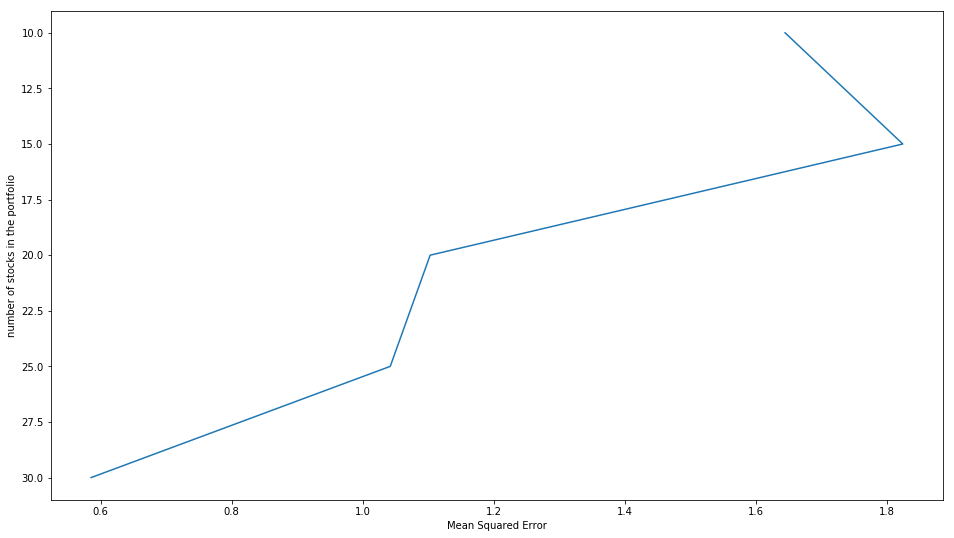

In [15]:
# Plot Efficient Deep Frontier

mse = [t/122 for t in error]
plt.gca().invert_yaxis()
plt.plot(mse, list(range(10,31,5)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 